In [20]:
from src.MO_DQN import MO_DQN
import mo_gymnasium as mo_gym
from src.gridsearch import gridsearch
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

### Configure and run the experiments

In [21]:
#experiment configurations
env_config_1 = {
        "collision_reward": -1,
        "observation": {
            "type": "MultiAgentObservation",
            "observation_config": {
                "type": "OccupancyGrid",
                "vehicles_count": 15,
                "features": ["presence", "x", "y", "vx", "vy"],
                "features_range": {
                    "x": [-100, 100],
                    "y": [-100, 100],
                    "vx": [-20, 20],
                    "vy": [-20, 20]
                },
                "grid_size": [[-27.5, 27.5], [-27.5, 27.5]],
                "grid_step": [5, 5],
            }
        }
    }

run_config = {
    "env": [env_config_1],
    "init": {
         "gamma": [0.9],
         "replay_buffer_size": [100], #1000
         "use_reward_normalisation_wrapper": [False],
         "use_default_reward_normalisation": [True],
         "network_hidden_sizes": [[128,128],[128,128,128],[128,64,32]]

    },
    "train": {
         "num_iterations" : 150_000,
         "inv_target_update_frequency": 20,
         "epsilon_start": 0.9,
         "epsilon_end": 0
    },
    "eval": {
        "num_repetitions": 20,
        "num_points": 30,
        "episode_recording_interval": None,
        "render_episodes": False
    },
}

In [22]:
#run the experiments
env = mo_gym.make('mo-highway-env-v0', render_mode='rgb_array')
gridsearch(MO_DQN, env, run_config, 11, csv_file_path="data/network_sizes/")


Training iterations:  83%|████████▎ | 123828/150000 [2:03:06<25:42, 16.96it/s] 

### Data preprocessing

In [9]:
#load the data
df_complete = pd.read_csv("data/network_sizes/experiment_merged.csv")
display(df_complete.info())
display(df_complete)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1980 entries, 0 to 1979
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        1980 non-null   int64  
 1   repetition_number                 1980 non-null   int64  
 2   weight_index                      1980 non-null   int64  
 3   weight_tuple                      1980 non-null   object 
 4   num_iterations                    1980 non-null   int64  
 5   normalised_speed_reward           1980 non-null   float64
 6   normalised_energy_reward          1980 non-null   float64
 7   raw_speed_reward                  1980 non-null   float64
 8   raw_energy_reward                 1980 non-null   float64
 9   env_config_id                     1980 non-null   int64  
 10  gamma                             1980 non-null   float64
 11  replay_buffer_size                1980 non-null   int64  
 12  use_re

None

,Unnamed: 0,repetition_number,weight_index,weight_tuple,num_iterations,normalised_speed_reward,normalised_energy_reward,raw_speed_reward,raw_energy_reward,env_config_id,gamma,replay_buffer_size,use_reward_normalisation_wrapper,use_default_reward_normalisation,network_hidden_sizes
0,0,0,0,"[0.0, 1.0]",80,0.122074,0.909024,9.765906,72.721936,0,0.9,100,False,True,"[128, 128]"
1,1,1,0,"[0.0, 1.0]",80,0.057680,0.890023,4.614390,71.201844,0,0.9,100,False,True,"[128, 128]"
2,2,2,0,"[0.0, 1.0]",80,0.069044,0.886256,5.523481,70.900460,0,0.9,100,False,True,"[128, 128]"
3,3,3,0,"[0.0, 1.0]",80,0.300104,0.890352,24.008330,71.228194,0,0.9,100,False,True,"[128, 128]"
4,4,4,0,"[0.0, 1.0]",80,0.146695,0.941211,11.735602,75.296870,0,0.9,100,False,True,"[128, 128]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1975,655,15,32,"[1.0, 0.0]",5,0.561975,0.202585,2.809873,1.012923,0,0.9,100,False,True,"[128, 64, 32]"
1976,656,16,32,"[1.0, 0.0]",25,0.859061,0.486783,21.476519,12.169568,0,0.9,100,False,True,"[128, 64, 32]"
1977,657,17,32,"[1.0, 0.0]",10,0.738561,0.371107,7.385610,3.711070,0,0.9,100,False,True,"[128, 64, 32]"
1978,658,18,32,"[1.0, 0.0]",10,0.765834,0.398380,7.658337,3.983798,0,0.9,100,False,True,"[128, 64, 32]"


In [11]:
#preprocess the dataframe
multi_index_list = ["network_hidden_sizes"]
value_list = ['normalised_speed_reward', 'normalised_energy_reward']
table = pd.pivot_table(df_complete, values=value_list, index=multi_index_list,
                        columns=['weight_index'], aggfunc="mean")
table = table.reset_index()
table['experiment_index'] = table.index
display(table)

network_hidden_sizes normalised_energy_reward            \
weight_index                                             0         1   
0                 [128, 128, 128]                 0.958860  0.975526   
1                      [128, 128]                 0.850828  0.764714   
2                   [128, 64, 32]                 0.721127  0.633661   

                                                                          \
weight_index         2         3         4         5         6         7   
0             0.954314  0.951284  0.952799  0.961890  0.964920  0.961890   
1             0.872456  0.814903  0.790107  0.833179  0.786617  0.820169   
2             0.650362  0.647282  0.710087  0.697502  0.691764  0.685745   

                        ... normalised_speed_reward                      \
weight_index         8  ...                      24        25        26   
0             0.939163  ...                0.722322  0.701243  0.710943   
1             0.815437  ...                0.724714  0.641737  0.665772   
2             0.699321  ...                0.392192  0.413453  0.494872   

                                                                          \
weight_index        27        28        29        30        31        32   
0             0.607091  0.629358  0.657509  0.698208  0.701803  0.754352   
1             0.749865  0.728633  0.751894  0.696490  0.700885  0.731061   
2             0.621479  0.612138  0.685794  0.640381  0.648833  0.674908   

             experiment_index  
weight_index                   
0                           0  
1                           1  
2                           2  

[3 rows x 68 columns]

In [13]:
multi_index_list = ['network_hidden_sizes', "weight_index"]

grouped_df = df_complete.groupby(multi_index_list)[value_list].mean()
index = grouped_df.index
grouped_df = grouped_df.reset_index()
grouped_df.set_index(index, inplace=True)
multi_index_list.remove("weight_index")
grouped_df["experiment"] = grouped_df[multi_index_list].apply(tuple, axis=1)
display(grouped_df.info())
display(grouped_df)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 99 entries, ('[128, 128, 128]', 0) to ('[128, 64, 32]', 32)
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   network_hidden_sizes      99 non-null     object 
 1   weight_index              99 non-null     int64  
 2   normalised_speed_reward   99 non-null     float64
 3   normalised_energy_reward  99 non-null     float64
 4   experiment                99 non-null     object 
dtypes: float64(2), int64(1), object(2)
memory usage: 5.6+ KB


None

network_hidden_sizes  weight_index  \
network_hidden_sizes weight_index                                      
[128, 128, 128]      0                 [128, 128, 128]             0   
                     1                 [128, 128, 128]             1   
                     2                 [128, 128, 128]             2   
                     3                 [128, 128, 128]             3   
                     4                 [128, 128, 128]             4   
...                                                ...           ...   
[128, 64, 32]        28                  [128, 64, 32]            28   
                     29                  [128, 64, 32]            29   
                     30                  [128, 64, 32]            30   
                     31                  [128, 64, 32]            31   
                     32                  [128, 64, 32]            32   

                                   normalised_speed_reward  \
network_hidden_sizes weight_index                            
[128, 128, 128]      0                            0.050862   
                     1                            0.067528   
                     2                            0.046316   
                     3                            0.043286   
                     4                            0.044801   
...                                                    ...   
[128, 64, 32]        28                           0.612138   
                     29                           0.685794   
                     30                           0.640381   
                     31                           0.648833   
                     32                           0.674908   

                                   normalised_energy_reward  \
network_hidden_sizes weight_index                             
[128, 128, 128]      0                             0.958860   
                     1                             0.975526   
                     2                             0.954314   
                     3                             0.951284   
                     4                             0.952799   
...                                                     ...   
[128, 64, 32]        28                            0.253190   
                     29                            0.322450   
                     30                            0.279658   
                     31                            0.285779   
                     32                            0.311473   

                                           experiment  
network_hidden_sizes weight_index                      
[128, 128, 128]      0             ([128, 128, 128],)  
                     1             ([128, 128, 128],)  
                     2             ([128, 128, 128],)  
                     3             ([128, 128, 128],)  
                     4             ([128, 128, 128],)  
...                                               ...  
[128, 64, 32]        28              ([128, 64, 32],)  
                     29              ([128, 64, 32],)  
                     30              ([128, 64, 32],)  
                     31              ([128, 64, 32],)  
                     32              ([128, 64, 32],)  

[99 rows x 5 columns]

In [15]:
nds = NonDominatedSorting()
value_columns = ["normalised_speed_reward", "normalised_energy_reward"]
#add pareto information
grouped_df["pareto"] = False
experiment_indices = grouped_df["experiment"].unique()
for index in experiment_indices:
    #get data of a specific experiment
    data = grouped_df[grouped_df["experiment"] == index]
    #compute the indices containing non-dominated points
    pareto_indices = nds.do(-1 * data[value_columns], only_non_dominated_front=True)
    #set pareto flag to True at the corresponding indices of the entire dataframe
    grouped_df.loc[(grouped_df["experiment"] == index) & (data["weight_index"].isin(pareto_indices)),"pareto"] = True

<Axes: xlabel='normalised_speed_reward', ylabel='normalised_energy_reward'>

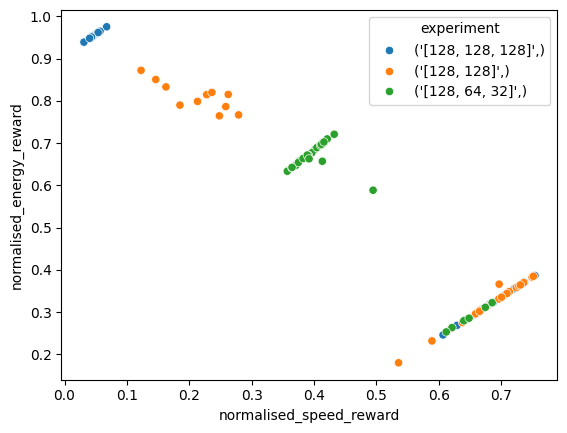

In [16]:
#plot all points
import seaborn as sns
sns.scatterplot(data=grouped_df, x='normalised_speed_reward', y='normalised_energy_reward', hue="experiment")

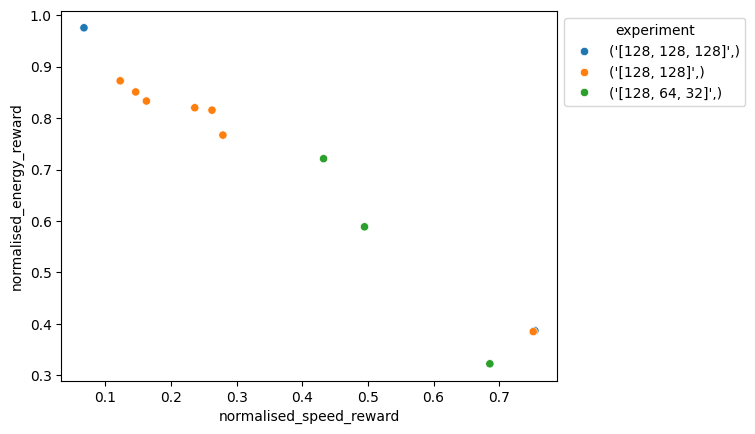

In [17]:
#plot only non-dominated points
ax = sns.scatterplot(data=grouped_df[grouped_df["pareto"]==True], x='normalised_speed_reward', y='normalised_energy_reward', hue="experiment")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [18]:
# num iterations
multi_index_list = ['network_hidden_sizes', "weight_index"]
value_list = ["num_iterations"]
grouped_df = df_complete.groupby(multi_index_list)[value_list].mean()
index = grouped_df.index
grouped_df = grouped_df.reset_index()
grouped_df.set_index(index, inplace=True)
multi_index_list.remove("weight_index")
grouped_df["experiment"] = grouped_df[multi_index_list].apply(tuple, axis=1)

env_config_id  weight_index
0              0               58.000000
               1               48.383333
               2               56.850000
               3               51.600000
               4               53.783333
               5               55.516667
               6               49.416667
               7               51.650000
               8               50.283333
               9               49.483333
               10              48.150000
               11              15.183333
               12              13.916667
               13              13.166667
               14              13.633333
               15              12.850000
               16              14.216667
               17              14.533333
               18              14.583333
               19              15.166667
               20              14.516667
               21              13.766667
               22              14.950000
               23            

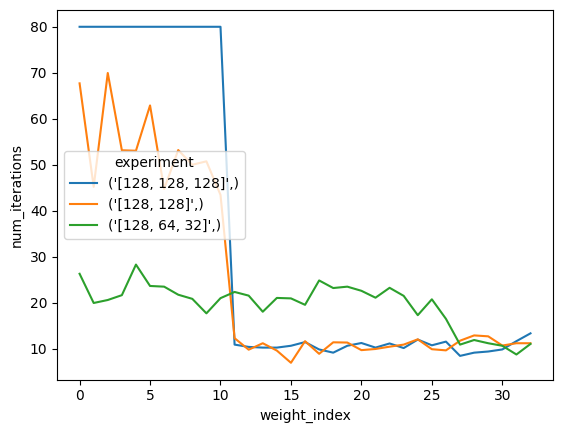

In [19]:
ax = sns.lineplot(grouped_df, x="weight_index", y="num_iterations", hue="experiment")
sns.move_legend(ax, "center left")

df_complete.groupby(["env_config_id", "weight_index"])["num_iterations"].mean()

experiment_id 0 --> collision reward -1
experiment_id 1 --> collision reward 0
--> collision reward of -1 works better.